# Analisis para cuantificar el contenido ofensivo en las "Reviews"

In [2]:
%matplotlib inline
from pathlib import Path
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob, Word
from sklearn.externals import joblib
import json
import cx_Oracle
import nltk

### SQL para todas las review

Obtener la totaldad de las reviews en DWH de infojobs

In [3]:
#TODAS LAS REVIEWS EXISTENTES EN DWH
con =  cx_Oracle.connect('comprasweb_ij/Xxxx1234!@10.10.2.223/MKTG')
print(con.version)

df = pd.read_sql_query('''
SELECT * 
FROM 
(
SELECT 
	RATINGEVENTOBJECTTARGETID,
	s.DT,
	TRUNC(s.RATINGEVENTOBJECTINSTANT) AS fecha_review,
	s.RATINGEVENTOBJECTSCORE,
	REPLACE(REPLACE(s.REVIEWNAME, '?', 'n'),'n', 'n') AS REVIEWNAME,
    REPLACE(REPLACE(s.REVIEWVALUE, '?', 'n'),'n', 'n') AS REVIEWVALUE
FROM DWHPRO.COMPANY_REVIEW s 
)t 
pivot (
min(REVIEWVALUE) value FOR REVIEWNAME IN ('title', 'description')
)
''', con)

df_save = df

con.close()

11.2.0.3.0


In [4]:
df.shape

(1480515, 6)

In [5]:
#rename para los merge entre df
df = df.rename(columns={"RATINGEVENTOBJECTTARGETID": "EXPERIENCE_ID"
                            ,"DT": "FECHA"
                            ,"RATINGEVENTOBJECTSCORE": "RATING"
                            ,"'title'_VALUE": "TITLE"
                            ,"'description'_VALUE": "DESCRIPTION"
                           })

In [6]:
#df['T+D'] = df[['TITLE', 'DESCRIPTION']].apply(lambda x: ''.join(x), axis=1)
df['TD'] = df.TITLE.astype(str).str.cat(df.DESCRIPTION.astype(str), sep=' ')

#### Flag para aquellas con score menor a 3

Se crea este True/False segun las estrellas para contrastar la informacion de contenido ofensivo ya que es posible que estas reviews tenga una valoracion baja

In [7]:
df["is_bad_review"] = df["RATING"].apply(lambda x: 1 if x < 3 else 0)
df.head()

,EXPERIENCE_ID,FECHA,FECHA_REVIEW,RATING,TITLE,DESCRIPTION,TD,is_bad_review
0,34100484352,2018-09-05,2018-09-05,5,Empresa internacional en Espa?a,None,Empresa internacional en Espa?a None,0
1,8548593044,2018-09-05,2018-09-05,4,Pendiente,Pendiente,Pendiente Pendiente,0
2,34112267816,2018-09-06,2018-09-06,3,Una empresa buena,None,Una empresa buena None,0
3,34108111430,2018-09-06,2018-09-06,4,Gestion de equipos,None,Gestion de equipos None,0
4,34101032986,2018-09-05,2018-09-05,4,Empresa seria y responsable.,Empresa seria y responsable. Responden cuando ...,Empresa seria y responsable. Empresa seria y r...,0


In [8]:
#quitar caracteres extraños de la bbdd manualmente (no es un tratamiento de texto, es un error en el ETL)
df["TD"] = df["TD"].apply(lambda x: 
x.replace("!", "").replace("?", "n").replace("Enter", "").replace("enter", "").replace("None", "").replace("#", "")
)

In [17]:
#eliminar registros con D y T Null (descripcion + titulo)
df_example = df[df['TD'].notnull()]

In [11]:
df[df['TD'].isnull()]

,EXPERIENCE_ID,FECHA,FECHA_REVIEW,RATING,TITLE,DESCRIPTION,TD,is_bad_review


In [18]:
df_example.shape

(1480515, 8)

Existen 1,4MM de reviews, este numero es el total sin considerar la normalización de compañias

### Limpieza de texto y reduccion de palabras

In [12]:
import string
punctuation=string.punctuation

In [13]:
from nltk.corpus import stopwords

In [14]:
stop = stopwords.words('spanish')

In [22]:
#modelo en español
import spacy
nlp = spacy.load('es_core_news_sm')

In [16]:
def cleanup_text(docs, logging=False):
    texts = []
    doc = nlp(docs, disable=['parser', 'ner'])
    tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
    tokens = [tok for tok in tokens if tok not in stop and tok not in punctuation]
    tokens = ' '.join(tokens)
    texts.append(tokens)
    return pd.Series(texts)

Se agrega una nueva columna para futuros analisis con el texto limpio (sin puntuaciones, stopword, numeros, entre otros)

In [19]:
df_example['clean_text'] = df_example['TD'].apply(lambda x: cleanup_text(x, False))

In [20]:
df_example.to_csv('df_example.csv', index= False)
#, sep=';')

In [592]:
#Load the data con listado de insultos 
df_example = pd.read_csv('df_example.csv')#, encoding='latin-1', sep='|', header=None)

In [21]:
df_example.shape

(1480515, 9)

#### Cantidad de reviews por dia

In [23]:
x = df_example['FECHA'].value_counts () 
y = pd.DataFrame(x)

In [24]:
y=y.reset_index(level=0)

In [25]:
y = y.rename(columns={"index": "Fecha"
                            ,"FECHA": "count_review"
                           })

In [26]:
y['Fecha'] = pd.to_datetime(y['Fecha'])

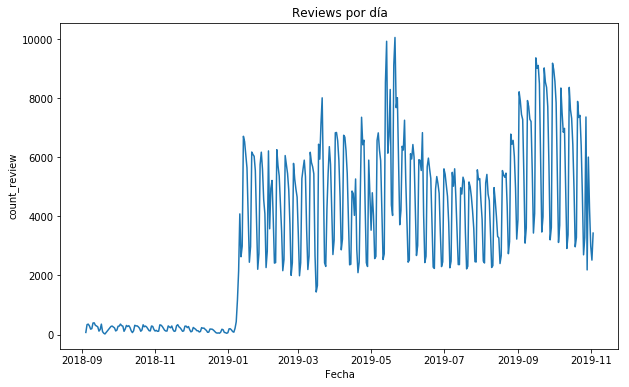

In [27]:
plt.figure(figsize = (10,6)) 
plt.title ("Reviews por día") 
ax = sns.lineplot(x="Fecha", y="count_review", data=y)

### Plot resultados segun Score

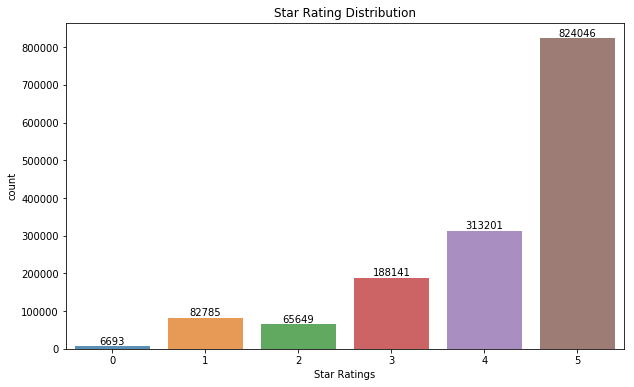

In [28]:
x = df_example['RATING'].value_counts () 
x = x.sort_index () 
plt.figure(figsize = (10,6)) 
ax = sns.barplot (x.index, x.values, alpha = 0.8) 
plt.title ("Star Rating Distribution") 
plt.ylabel ('count') 
plt.xlabel ('Star Ratings') 
rects = ax.patches 
labels = x.values 
for rect, label in zip (rects, labels): 
    height = rect.get_height () 
    ax.text (rect.get_x () + rect.get_width () / 2, height + 5, label, ha = 'center', va = 'bottom') 
plt.show ();

El potencial de Reviews con contenido prohibido son las Bad Reviews (menor a 3 estrellas) que son 75k = 1 y 60k = 2

### Agregar Blacklist para etiquetar registros con alguna de las palabras en el listado

filtro manual de una lista reducida de palabras claves

In [29]:
#Load the data con listado de insultos 
df_csv = pd.read_csv('listado_v2.csv')#, encoding='latin-1', sep='|', header=None)

In [30]:
df_csv=df_csv['Palabra_x1'].str.lower()

In [31]:
df_csv = df_csv.tolist()

Exploramos nuestra blacklist, que nos sirve para identificar revies que contengan alguna de las palabras del listado

In [32]:
for x in range(len(df_csv)): 
    print (df_csv[x])

abrillantaglandes
alcornoke
alcornoque
alelada
alelado
alelao
amorfo
asaltacunas
atontada
atontado
atontao
baboso
bastarda
bastardo
bigotezorra
bleda
boba
bobo
bobolaverga
bobomierda
bocachancla
bocachocho
bocafiemo
boludo
borracha
borracho
burro
buscabregues
chorlito
cabezabuque
cabezakiko
cabron
cabrona
cabronazo
cabrón
cachomierda
caga
cagablando
cagadubtes
cagaestacas
cagalindes
cagon
cagaportales
cagan
caquita
canalla
capulla
capullo
capuyo
capuya
caracoño
caracono
caracul
caraculo
carajote
caramierda
caranabo
carapolla
caraputa
caxomierda
chalada
chalado
chalao
chingada
chosco
chupaescrotos
chupamela
chupasangre
chusma
comemierda
comemierdas
comemocos
comepollas
comeprepucios
cretina
cretino
culo
culos
descalzaputas
descerebrado
desgraciada
desgraciado
desgraciao
donnadie
empujamierda
enderezaplátanos
energumena
energumeno
energúmena
energúmeno
engendro
escoria
estupida
estupido
estúpida
estúpido
eunuco
facha
facho
fea
feminazi
feo
feto
follacabras
follagatos
follácaros
folla
fol

In [33]:
lista_insultos = df_csv

In [34]:
#tokens dentro de la misma columna
def preprocessing(text):
    #text = text.decode("utf8")
    # tokenize into words
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]

    return tokens 


In [35]:
df_example['clean_text'] = df_example['clean_text'].astype(str)

In [36]:
df_example['token_text'] = df_example['clean_text'].apply(lambda x: preprocessing(x))

In [37]:
%whos

Variable         Type                    Data/Info
--------------------------------------------------
Path             type                    <class 'pathlib.Path'>
TextBlob         type                    <class 'textblob.blob.TextBlob'>
Word             type                    <class 'textblob.blob.Word'>
ax               AxesSubplot             AxesSubplot(0.125,0.125;0.775x0.755)
cleanup_text     function                <function cleanup_text at 0x1a2fafa6a8>
con              Connection              <cx_Oracle.Connection to <...>sweb_ij@10.10.2.223/MKTG>
cx_Oracle        module                  <module 'cx_Oracle' from <...>e.cpython-37m-darwin.so'>
df               DataFrame                        EXPERIENCE_ID   <...>1480515 rows x 8 columns]
df_csv           list                    n=277
df_example       DataFrame                        EXPERIENCE_ID   <...>480515 rows x 10 columns]
df_save          DataFrame                        RATINGEVENTOBJEC<...>1480515 rows x 6 columns]

Agregar nueva columna True/False, que busca dentro del texto que haga match con alguna palabra de la blacklist

In [38]:
#Funcion que busca alguna palabra dentro de cada registro y que pertenezca al listado de insultos
df_example['es_insulto'] = df_example['token_text'].apply(lambda x: any([k in x for k in lista_insultos]))

### Plot del listado vs el total de reviews

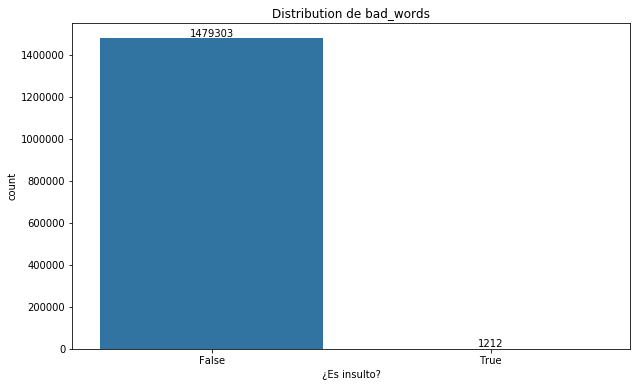

In [39]:
x = df_example['es_insulto'].value_counts () 
x = x.sort_index () 
plt.figure(figsize = (10,6)) 
ax = sns.barplot (x.index, x.values, alpha = 1) 
plt.title ("Distribution de bad_words") 
plt.ylabel ('count') 
plt.xlabel ('¿Es insulto?') 
rects = ax.patches 
labels = x.values 
for rect, label in zip (rects, labels): 
    height = rect.get_height () 
    ax.text (rect.get_x () + rect.get_width () / 2, height + 5, label, ha = 'center', va = 'bottom') 
plt.show ();

Este primer paso encuentra 1212

reviews con posibles insultos en su contenido

#### Ver en profundidad si estos insultos tienen una nota mayor o menor a 3

In [40]:
#dataframe con solo insulto = True
df_insultos = df_example[df_example['es_insulto']==True]

In [41]:
df_insultos.to_csv('df_insultos_dicc_2.csv', index= False)
#, sep=';')

In [42]:
df_insultos.shape

(1212, 11)

In [43]:
df_insultos[df_insultos['is_bad_review']==0]

,EXPERIENCE_ID,FECHA,FECHA_REVIEW,RATING,TITLE,DESCRIPTION,TD,is_bad_review,clean_text,token_text,es_insulto
1998,34198872839,2019-09-14,2019-09-14,5,Ya,Le encanta pronunciar palabras bien sonantes y...,Ya Le encanta pronunciar palabras bien sonante...,0,encantar pronunciar palabra bien sonante asi d...,"[encantar, pronunciar, palabra, bien, sonante,...",True
6329,34195520743,2019-06-27,2019-06-27,3,Lo malo es que sabes a la hora que entras pero...,Los encargados son un poco cabrones. pero el h...,Lo malo es que sabes a la hora que entras pero...,0,malo ser saber hora entrar salir hacia mas hor...,"[malo, ser, saber, hora, entrar, salir, hacia,...",True
11321,34196265396,2019-06-07,2019-06-07,4,una mierda,mal pagado,una mierda mal pagado,0,mierda mal pagar,"[mierda, mal, pagar]",True
32686,34195294382,2019-05-08,2019-05-08,3,Lo das todo y nunca es suficiente. Eres una mi...,Malas personas.,Lo das todo y nunca es suficiente. Eres una mi...,0,dar nunca ser suficiente mierda parir malas pe...,"[dar, nunca, ser, suficiente, mierda, parir, m...",True
35803,34197863716,2019-08-11,2019-08-11,5,Pelele,Klsksksksk,Pelele Klsksksksk,0,pelele klsksksksk,"[pelele, klsksksksk]",True
37648,32143339910,2019-06-22,2019-06-22,3,esta bien para empezar y despues cambiar,"buen rollo con lo empleados ,oficinas una mier...",esta bien para empezar y despues cambiar buen ...,0,bien parir empezar despues cambiar bueno rollo...,"[bien, parir, empezar, despues, cambiar, bueno...",True
40415,34197699227,2019-08-03,2019-08-03,5,De puta madre,De puta madre,De puta madre De puta madre,0,puto madre puto madre,"[puto, madre, puto, madre]",True
43280,28753215954,2019-06-18,2019-06-18,3,una mierda,es una empresa donde te estancas,una mierda es una empresa donde te estancas,0,mierda ser empresa estanco,"[mierda, ser, empresa, estanco]",True
45605,34200296955,2019-10-22,2019-10-22,5,Pinche de cocina y monitora de comedor,Buen ambiente de trabajo y te ayudan a progres...,Pinche de cocina y monitora de comedor Buen am...,0,pinche cocinar monitor comedor buen ambientar ...,"[pinche, cocinar, monitor, comedor, buen, ambi...",True
46928,34193960838,2019-03-23,2019-03-23,4,Buen ambiente,"Bien yo estuve Agusti, hasta que la cagaron co...","Buen ambiente Bien yo estuve Agusti, hasta que...",0,buen ambientar bien agusti cagar campana medio...,"[buen, ambientar, bien, agusti, cagar, campana...",True


Ahora que tenemos este nuevo dataframe vamos a ver la distribucion segun las estrellas de cada valoracion

### Plot de flag = true y con score menor a 3

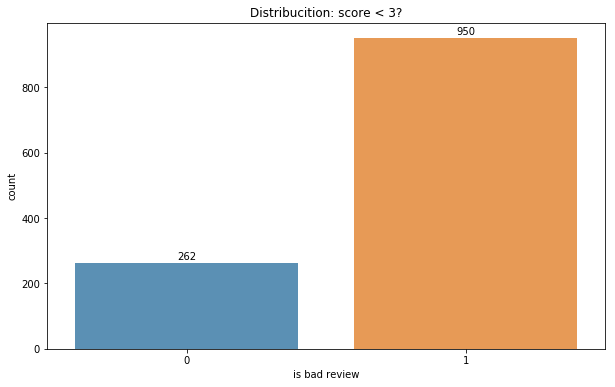

In [45]:
x = df_insultos['is_bad_review'].value_counts () 
x = x.sort_index () 
plt.figure(figsize = (10,6)) 
ax = sns.barplot (x.index, x.values, alpha = 0.8) 
plt.title ("Distribucition: score < 3?") 
plt.ylabel ('count') 
plt.xlabel ('is bad review') 
rects = ax.patches 
labels = x.values 
for rect, label in zip (rects, labels): 
    height = rect.get_height () 
    ax.text (rect.get_x () + rect.get_width () / 2, height + 5, label, ha = 'center', va = 'bottom') 
plt.show ();

Existen 950 reviews, las cuales tienen alguna palabra ofensiva y ademas tienen una puntuacion menor a 3 estrellas

In [46]:
x = df_insultos['FECHA'].value_counts () 
y = pd.DataFrame(x)

In [47]:
y=y.reset_index(level=0)

In [48]:
y = y.rename(columns={"index": "Fecha"
                            ,"FECHA": "count_review"
                           })

In [49]:
y['Fecha'] = pd.to_datetime(y['Fecha'])

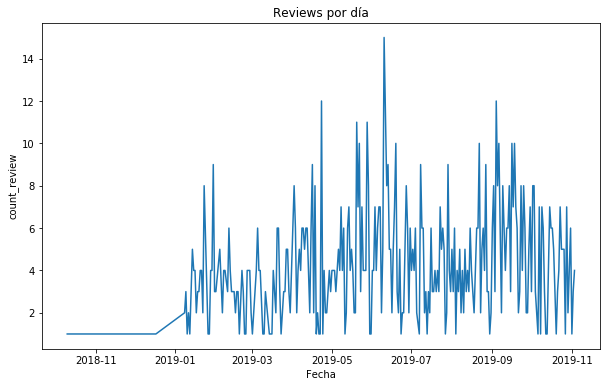

In [50]:
plt.figure(figsize = (10,6)) 
plt.title ("Reviews por día") 
ax = sns.lineplot(x="Fecha", y="count_review", data=y)

Diariamente no hay mas de 15 Reviews consideradas ofensivas con este primer modelo

### Ahora el mismo analisis pero con Normalizacion de Empresas

el modelo anterior considera todas las posibles reviews (lo cual debe ser), solo se hará este paso con empresas normalizadas ya que es lo que realmente se esta pintando. Para analizar las reviews se debe considerar el volumen TOTAL

In [53]:
#Load the data
df_company_reviews = pd.read_csv('reviews_all_df.csv')#, encoding='', sep='|', header=None)

In [54]:
df_company_reviews.shape

(548272, 8)

se reduce la cantidad de 1,5MM a 548k de reviews, todo el resto no cruza con empresas normalizas por lo cual no se pueden pintar

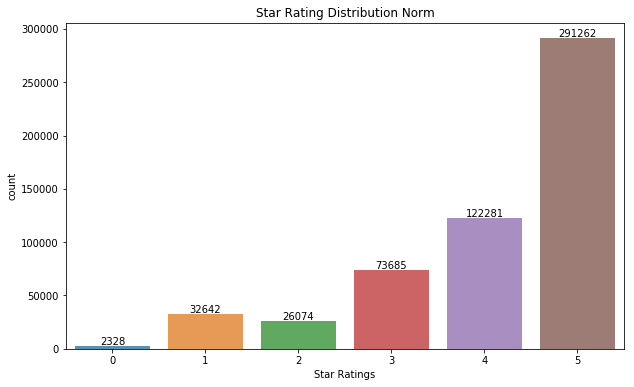

In [55]:
x = df_company_reviews['SCORE'].value_counts () 
x = x.sort_index () 
plt.figure(figsize = (10,6)) 
ax = sns.barplot (x.index, x.values, alpha = 0.8) 
plt.title ("Star Rating Distribution Norm") 
plt.ylabel ('count') 
plt.xlabel ('Star Ratings') 
rects = ax.patches 
labels = x.values 
for rect, label in zip (rects, labels): 
    height = rect.get_height () 
    ax.text (rect.get_x () + rect.get_width () / 2, height + 5, label, ha = 'center', va = 'bottom') 
plt.show ();

potencial de revies con contenido ofensivo 32k + 26k

Si queremos ver por dia:

In [56]:
x = df_company_reviews['DATE_REVIEW'].value_counts () 
y = pd.DataFrame(x)

In [57]:
y=y.reset_index(level=0)

In [58]:
y = y.rename(columns={"index": "Fecha"
                            ,"DATE_REVIEW": "count_review"
                           })

In [59]:
y['Fecha'] = pd.to_datetime(y['Fecha'])

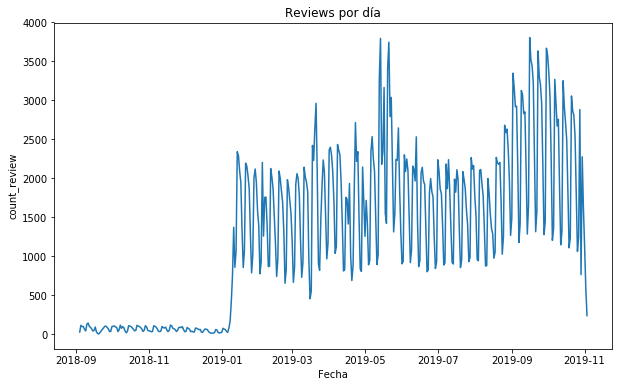

In [60]:
plt.figure(figsize = (10,6)) 
plt.title ("Reviews por día") 
ax = sns.lineplot(x="Fecha", y="count_review", data=y)

Actualmente no supera las 4000 reviews normalizadas por dia

A continuacion se aplica la misma funcion que detecta el contenido dentro de la review con alguna palabra de la blacklist

In [61]:
#df['T+D'] = df[['TITLE', 'DESCRIPTION']].apply(lambda x: ''.join(x), axis=1)
df_company_reviews['TD'] = df_company_reviews.TITLE.astype(str).str.cat(df_company_reviews.DESCRIPTION.astype(str), sep=' ')

In [494]:
df_company_reviews = df_company_reviews[df_company_reviews['TD'].notnull()]

In [62]:
df_company_reviews['clean_text'] = df_company_reviews['TD'].apply(lambda x: cleanup_text(x, False))

In [63]:
df_company_reviews['token_text'] = df_company_reviews['clean_text'].apply(lambda x: preprocessing(x))

In [64]:
df_company_reviews['es_insulto'] = df_company_reviews['token_text'].apply(lambda x: any([k in x for k in lista_insultos]))

In [65]:
df_company_reviews["is_bad_review"] = df_company_reviews["SCORE"].apply(lambda x: 1 if x < 3 else 0)

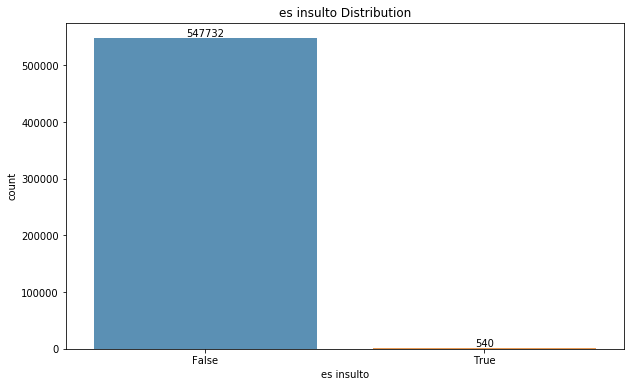

In [66]:
x = df_company_reviews['es_insulto'].value_counts () 
x = x.sort_index () 
plt.figure(figsize = (10,6)) 
ax = sns.barplot (x.index, x.values, alpha = 0.8) 
plt.title ("es insulto Distribution") 
plt.ylabel ('count') 
plt.xlabel ('es insulto') 
rects = ax.patches 
labels = x.values 
for rect, label in zip (rects, labels): 
    height = rect.get_height () 
    ax.text (rect.get_x () + rect.get_width () / 2, height + 5, label, ha = 'center', va = 'bottom') 
plt.show ();

Se detectan 540 reviews normalizadas con posible contenido ofensivo

In [67]:
df_insultos_norm = df_company_reviews[df_company_reviews['es_insulto']==True]

In [68]:
df_insultos_norm.shape

(540, 13)

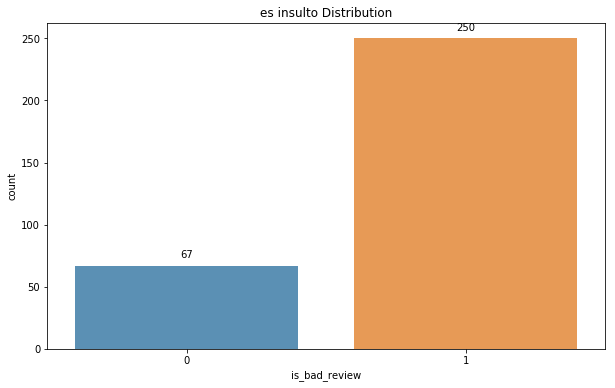

In [506]:
x = df_insultos_norm['is_bad_review'].value_counts () 
x = x.sort_index () 
plt.figure(figsize = (10,6)) 
ax = sns.barplot (x.index, x.values, alpha = 0.8) 
plt.title ("es insulto Distribution") 
plt.ylabel ('count') 
plt.xlabel ('is_bad_review') 
rects = ax.patches 
labels = x.values 
for rect, label in zip (rects, labels): 
    height = rect.get_height () 
    ax.text (rect.get_x () + rect.get_width () / 2, height + 5, label, ha = 'center', va = 'bottom') 
plt.show ();

de las cuales 250 tienen una puntuacion menor a 3 estrellas.

### Modelo simple

para detectar una mayor cantidad de revies, se va a tratar el texto quitando solo stop words y puntuacion, no se hará reduccion de palabras

In [508]:
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer


In [509]:
def basic_clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    
    # remove stop words
    stop = stopwords.words('spanish')
    text = [x for x in text if x not in stop]
   
    # remove empty tokens
    text = [t for t in text if len(t) > 0]

    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    
    # join all
    text = " ".join(text)
    
    return(text)

# clean text data
df_example["review_clean_simple"] = df_example["TD"].apply(lambda x: basic_clean_text(x))
#reviews_df

In [512]:
df_example['token_text_simple'] = df_example['review_clean_simple'].apply(lambda x: preprocessing(x))

In [513]:
#df_example['es_insulto_4'] = df_example['TD'].apply(lambda x: any([k in x for k in lista_insultos]))
df_example['es_insulto_simple'] = df_example['token_text_simple'].apply(lambda x: any([k in x for k in lista_insultos]))

In [531]:
df_simple = df_example[['EXPERIENCE_ID','FECHA','is_bad_review','RATING','TITLE','DESCRIPTION','TD','review_clean_simple','token_text_simple','es_insulto_simple']]

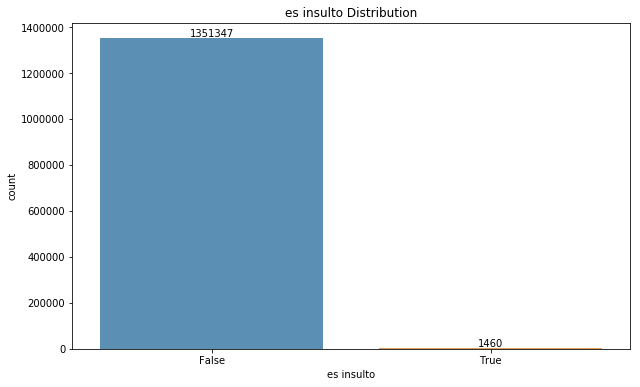

In [532]:
x = df_simple['es_insulto_simple'].value_counts () 
x = x.sort_index () 
plt.figure(figsize = (10,6)) 
ax = sns.barplot (x.index, x.values, alpha = 0.8) 
plt.title ("es insulto Distribution") 
plt.ylabel ('count') 
plt.xlabel ('es insulto') 
rects = ax.patches 
labels = x.values 
for rect, label in zip (rects, labels): 
    height = rect.get_height () 
    ax.text (rect.get_x () + rect.get_width () / 2, height + 5, label, ha = 'center', va = 'bottom') 
plt.show ();

para este modelo, se detectan 1460 reviews con posibla contenido ofensivo

In [533]:
df_simple = df_simple[df_simple['es_insulto_simple']==True]

In [534]:
df_simple.shape

(1460, 10)

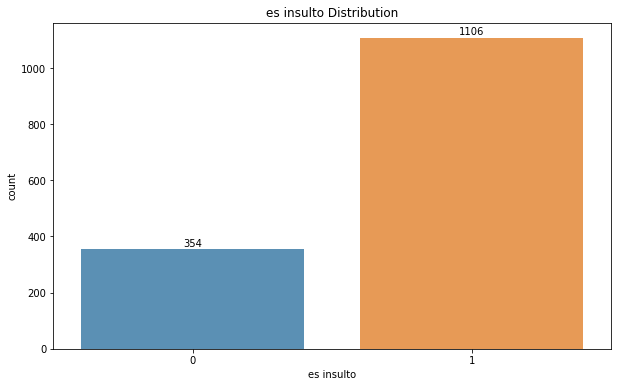

In [536]:
x = df_simple['is_bad_review'].value_counts () 
x = x.sort_index () 
plt.figure(figsize = (10,6)) 
ax = sns.barplot (x.index, x.values, alpha = 0.8) 
plt.title ("es insulto Distribution") 
plt.ylabel ('count') 
plt.xlabel ('es insulto') 
rects = ax.patches 
labels = x.values 
for rect, label in zip (rects, labels): 
    height = rect.get_height () 
    ax.text (rect.get_x () + rect.get_width () / 2, height + 5, label, ha = 'center', va = 'bottom') 
plt.show ();

el resultado es un poco menor al modelo anterior, por lo cual haremos la deteccion en base de datos con la funcion de Spacy, ahora podemos pintar en tableau, el score de cada review, empresa y ver el % de contenido ofensivo por cada una

Exportamos nuestros ID para hacer el cruce en el dashboard:

In [539]:
id_bad_reviews = df_simple[['EXPERIENCE_ID']]

In [563]:
id_bad_reviews.shape

(1460, 1)

In [540]:
id_bad_reviews.to_csv('id_bad_reviews.csv', index= False)
#, sep=';')

In [541]:
id_bad_reviews.shape

(1460, 1)

In [558]:
df_insultos.shape

(1544, 11)

In [559]:
df_id_exp = df_insultos[['EXPERIENCE_ID']]

In [561]:
df_id_exp.shape

(1544, 1)

In [562]:
df_id_exp.to_csv('id_bad_reviews_all.csv', index= False)
#, sep=';')

### Analizar reviews sin stopwords pero con nota 1 y 2

In [620]:
#dataframe con solo insulto = True
df_sin_blacklist = df_example[(df_example['es_insulto_7']==False)&(df_example['is_bad_review']==True)] 

In [622]:
df_sin_blacklist

,EXPERIENCE_ID,FECHA,RATING,TITLE,DESCRIPTION,TD,is_bad_review,clean_text,token_text,es_insulto_6,es_insulto_7
2,34111234384,2018-09-06,1,Muy mala experiencia,"Experiencia horrible, entre otras muchas cosas...","Muy mala experiencia Experiencia horrible, ent...",1,malo experiencia experiencia horrible entrar c...,"[malo, experiencia, experiencia, horrible, ent...",False,False
14,34102235558,2018-09-05,2,Desordeoganizacion,"Buen ambiente de trabajo, Desorden a nivel adm...","Desordeoganizacion Buen ambiente de trabajo, D...",1,desordeoganizacion buen ambientar trabajar des...,"[desordeoganizacion, buen, ambientar, trabajar...",False,False
41,34192894044,2019-02-19,2,APRENDIZAJE,EN MALAS CONDICIONES LABORABLES A PESAR DE !RE...,APRENDIZAJE EN MALAS CONDICIONES LABORABLES A ...,1,aprendizaje malas condiciones laborables pesar...,"[aprendizaje, malas, condiciones, laborables, ...",False,False
58,34197567981,2019-07-29,1,Explotacion del personal,No son buenos pagadores.,Explotacion del personal No son buenos pagadores.,1,explotacion personal ser bueno pagador,"[explotacion, personal, ser, bueno, pagador]",False,False
63,32762205670,2019-07-31,2,buena compa?ia pocos derechos,"buenas compa?eras, trabajo precario",buena compania pocos derechos buenas companera...,1,bueno compania derecho bueno companeras trabaj...,"[bueno, compania, derecho, bueno, companeras, ...",False,False
70,34197618445,2019-07-31,2,De muy malo a muy bueno lo dejo en malo.,"No se si es solo mi tienda, pero no recomendar...",De muy malo a muy bueno lo dejo en malo. No se...,1,malo bueno dejar malo si ser solo tender recom...,"[malo, bueno, dejar, malo, si, ser, solo, tend...",False,False
85,34195608608,2019-07-31,2,Prometen lo que no hay,"Poca seriedad, dicen que puedes trabajar unas ...","Prometen lo que no hay Poca seriedad, dicen qu...",1,prometen haber poca seriedad decir poder traba...,"[prometen, haber, poca, seriedad, decir, poder...",False,False
90,34197584196,2019-07-29,2,buena,buena,buena buena,1,bueno bueno,"[bueno, bueno]",False,False
112,31237166142,2019-01-13,2,Nada,Nada,Nada Nada,1,nan,[nan],False,False
114,32159390420,2019-01-13,2,Empresa con mucha rotacion de personal.,Empresa con mucha rotacion de personal.,Empresa con mucha rotacion de personal. Empres...,1,empresa rotacion personal empresa rotacion per...,"[empresa, rotacion, personal, empresa, rotacio...",False,False


## Analizar distribucion de reviews con caracteres especiales

#### para detectar emails

In [642]:
import re

df = pd.DataFrame({'Name': ['Amy', 'Ben', 'Christine', 'David'],
                    'Email': ['amy.l@hotmail.com',
                              'benm99artni@gmail.fr',
                              'c.mousse@example.com',
                              'd_zhangf@p.fr']},
                    columns=['Name', 'Email'])
df

p = r'^[a-z._0-9]+@[a-z]+\.[a-z]{2,3}'

df['Email'].apply(lambda x: re.findall(p, x))

0       [amy.l@hotmail.com]
1    [benm99artni@gmail.fr]
2    [c.mousse@example.com]
3           [d_zhangf@p.fr]
Name: Email, dtype: object

#### para detectar solo puntuaciones

In [1127]:
import re

df = pd.DataFrame({'Name': ['Amy', 'Ben', 'Christine', 'David'],
                    'review': ['hola esta!, review es ejemplo.',
                              'casd hola hola 123',
                              '1 ,  ..  1',
                              '123']},
                    columns=['Name', 'review'])
df

#p = '^[\W_]+$'
#p='^[0-9]+$'
p ='^[0-9 .,!-*%&]+$'

df['out'] = df['review'].apply(lambda x: re.match(p, x))
df

,Name,review,out
0,Amy,"hola esta!, review es ejemplo.",None
1,Ben,casd hola hola 123,None
2,Christine,"1 , .. 1","<re.Match object; span=(0, 10), match='1 , ....."
3,David,123,"<re.Match object; span=(0, 3), match='123'>"


In [1135]:
p = '^[\W_]+$'

df_final['title_is_punct'] = df_final['TITLE'].apply(lambda x: re.match(p, x))
df_final['title_is_punct'] = df_final['title_is_punct'].apply(lambda x: True if x != None else False)

In [1138]:
p = '^[\W_]+$'

df_final['desc_is_punct'] = df_final['DESCRIPTION'].apply(lambda x: re.match(p, x))
df_final['desc_is_punct'] = df_final['desc_is_punct'].apply(lambda x: True if x != None else False)

In [1139]:
df_final[df_final['desc_is_punct']==True]

,EXPERIENCE_ID,FECHA,PROVIDERCHANNEL,RATING,TITLE,DESCRIPTION,TD,is_bad_review,es_insulto_7,out_re,title_is_num,desc_is_num,title_is_ok,desc_is_ok,title_is_mal,desc_is_mal,len_title,len_desc,title_is_punct,desc_is_punct
7,34100723848,2018-09-05,desktop,5,.,.,. .,0,False,False,True,True,False,False,False,False,1,1,True,True
52,34111259682,2018-09-06,desktop,3,.,.,. .,0,False,False,True,True,False,False,False,False,1,1,True,True
61,34197571497,2019-07-29,android,4,.,.,. .,0,False,False,True,True,False,False,False,False,1,1,True,True
68,34197584089,2019-07-29,desktop,3,.,.,. .,0,False,False,True,True,False,False,False,False,1,1,True,True
119,34191607537,2019-01-13,desktop,5,.,.,. .,0,False,False,True,True,False,False,False,False,1,1,True,True
123,33173393224,2019-01-13,desktop,4,.,.,. .,0,False,False,True,True,False,False,False,False,1,1,True,True
125,34191594313,2019-01-13,desktop,5,.,.,. .,0,False,False,True,True,False,False,False,False,1,1,True,True
136,28278561974,2019-01-13,desktop,2,.,.,. .,1,False,False,True,True,False,False,False,False,1,1,True,True
139,34191605496,2019-01-13,desktop,5,.,.,. .,0,False,False,True,True,False,False,False,False,1,1,True,True
146,34191587488,2019-01-12,desktop,5,.,.,. .,0,False,False,True,True,False,False,False,False,1,1,True,True


In [774]:
df_puntos = df_final[df_final['out_re']==False]

In [775]:
#TODAS LAS REVIEWS EXISTENTES EN DWH
con =  cx_Oracle.connect('comprasweb_ij/Xxxx1234!@10.10.2.223/MKTG')
print(con.version)

df_platform = pd.read_sql_query('''
SELECT 
RATINGEVENTOBJECTTARGETID as EXPERIENCE_ID
,PROVIDERCHANNEL
FROM 
DWHPRO.COMPANY_REVIEW
GROUP BY 
RATINGEVENTOBJECTTARGETID
,PROVIDERCHANNEL
''', con)

con.close()

11.2.0.3.0


In [776]:
df_puntos = df_puntos.merge(df_platform,how='left',on = 'EXPERIENCE_ID')

In [784]:
df_puntos.to_csv('df_puntos.csv', index= False)
#, sep=';')

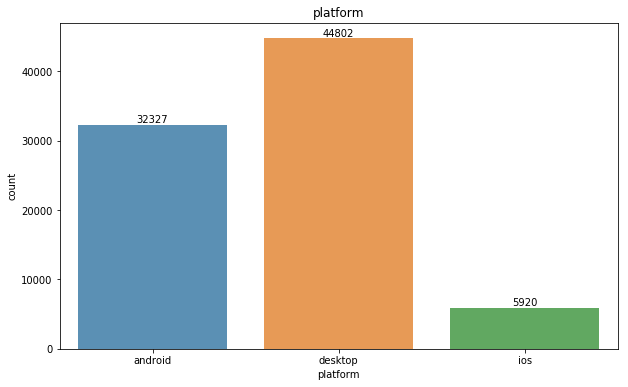

In [778]:
x = df_puntos['PROVIDERCHANNEL'].value_counts () 
x = x.sort_index () 
plt.figure(figsize = (10,6)) 
ax = sns.barplot (x.index, x.values, alpha = 0.8) 
plt.title ("platform") 
plt.ylabel ('count') 
plt.xlabel ('platform') 
rects = ax.patches 
labels = x.values 
for rect, label in zip (rects, labels): 
    height = rect.get_height () 
    ax.text (rect.get_x () + rect.get_width () / 2, height + 5, label, ha = 'center', va = 'bottom') 
plt.show ();

In [781]:
df_example = df_example.merge(df_platform,how='left',on = 'EXPERIENCE_ID')

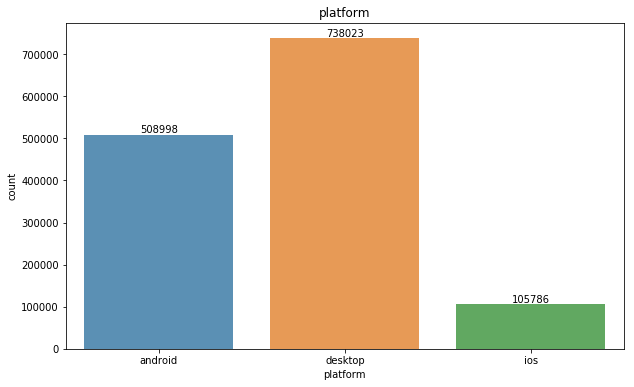

In [783]:
x = df_example['PROVIDERCHANNEL'].value_counts () 
x = x.sort_index () 
plt.figure(figsize = (10,6)) 
ax = sns.barplot (x.index, x.values, alpha = 0.8) 
plt.title ("platform") 
plt.ylabel ('count') 
plt.xlabel ('platform') 
rects = ax.patches 
labels = x.values 
for rect, label in zip (rects, labels): 
    height = rect.get_height () 
    ax.text (rect.get_x () + rect.get_width () / 2, height + 5, label, ha = 'center', va = 'bottom') 
plt.show ();

Android: 32.327 / 508.998 = 6,3%

Desktop: 44.802 / 738.023 = 6,0%

iOS: 5.920 / 105.786 = 5,6%

In [954]:
df_final = df_example

In [978]:
df_final = df_final[['EXPERIENCE_ID','FECHA','RATING','TITLE','DESCRIPTION','TD','is_bad_review',
                     'clean_text','token_text','es_insulto_7','out_re','PROVIDERCHANNEL']]
#df_campos finales

In [1128]:
#p = '^[0-9]+$'
p ='^[0-9 .,!-*%&]+$'

df_final['title_num'] = df_final['TITLE'].apply(lambda x: re.match(p, x))
df_final['title_is_num'] = df_final['title_num'].apply(lambda x: True if x != None else False)

In [1129]:
p ='^[0-9 .,!-*%&]+$'

df_final['desc_num'] = df_final['DESCRIPTION'].apply(lambda x: re.match(p, x))
df_final['desc_is_num'] = df_final['desc_num'].apply(lambda x: True if x != None else False)

In [1159]:
df_final['title_is_ok'] = df_final['TITLE'].apply(lambda x: True if str.lower(x) == 'ok' else False)
df_final['desc_is_ok'] = df_final['DESCRIPTION'].apply(lambda x: True if str.lower(x) == 'ok' else False)
df_final['title_is_mal'] = df_final['TITLE'].apply(lambda x: True if str.lower(x) == 'mal' else False)
df_final['desc_is_mal'] = df_final['DESCRIPTION'].apply(lambda x: True if str.lower(x) == 'mal' else False)
df_final['is_short_title'] = df_final['TITLE'].str.len()
df_final['is_short_desc'] = df_final['DESCRIPTION'].str.len()
df_final['is_short_title']=df_final['is_short_title'].apply(lambda x: True if x < 4 else False)
df_final['is_short_desc']=df_final['is_short_desc'].apply(lambda x: True if x < 4 else False)

In [1160]:
for col in df_final.columns: 
    print(col)

EXPERIENCE_ID
FECHA
PROVIDERCHANNEL
RATING
TITLE
DESCRIPTION
TD
is_bad_review
es_insulto
title_is_num
desc_is_num
title_is_ok
desc_is_ok
title_is_mal
desc_is_mal
len_title
len_desc
title_is_punct
desc_is_punct
is_short_title
is_short_desc


In [1150]:
df_final = df_final.rename(columns={'es_insulto_7': 'es_insulto'})

In [1162]:
df_final.to_csv('df_final_matriz.csv', index= True)
#, sep=';')

In [1164]:
df_final

,EXPERIENCE_ID,FECHA,PROVIDERCHANNEL,RATING,TITLE,DESCRIPTION,TD,is_bad_review,es_insulto,title_is_num,...,title_is_ok,desc_is_ok,title_is_mal,desc_is_mal,len_title,len_desc,title_is_punct,desc_is_punct,is_short_title,is_short_desc
0,34090727376,2018-09-04,desktop,5,Perfecto,Buen ambiente de trabajo y horarios flexibles.,Perfecto Buen ambiente de trabajo y horarios f...,0,False,False,...,False,False,False,False,8,46,False,False,False,False
1,34093085948,2018-09-04,desktop,5,EXPERIENCIA,Fantastica,EXPERIENCIA Fantastica,0,False,False,...,False,False,False,False,11,10,False,False,False,False
2,34111234384,2018-09-06,desktop,1,Muy mala experiencia,"Experiencia horrible, entre otras muchas cosas...","Muy mala experiencia Experiencia horrible, ent...",1,False,False,...,False,False,False,False,20,143,False,False,False,False
3,34105302148,2018-09-06,desktop,3,Buena empresa,Buena empresa,Buena empresa Buena empresa,0,False,False,...,False,False,False,False,13,13,False,False,False,False
4,34109805912,2018-09-06,desktop,3,Erasmus,Erasmus,Erasmus Erasmus,0,False,False,...,False,False,False,False,7,7,False,False,False,False
5,34108057940,2018-09-06,desktop,5,Buena,nan,Buena,0,False,False,...,False,False,False,False,5,3,False,False,False,True
6,34101513078,2018-09-05,desktop,3,BUEN APRENDIZAJE,BUENA EXPERIENCIA,BUEN APRENDIZAJE BUENA EXPERIENCIA,0,False,False,...,False,False,False,False,16,17,False,False,False,False
7,34100723848,2018-09-05,desktop,5,.,.,. .,0,False,True,...,False,False,False,False,1,1,True,True,True,True
8,20656823688,2018-09-08,desktop,4,Feliz,Muy bien,Feliz Muy bien,0,False,False,...,False,False,False,False,5,8,False,False,False,False
9,32905357922,2018-09-08,desktop,5,muchas ofertas,muy buena,muchas ofertas muy buena,0,False,False,...,False,False,False,False,14,9,False,False,False,False
